# Exercises for 2021-05-06

In this jupyter notebook, we will perform a dynamic mode decomposition (DMD) for two example problems, which differ only in a seemingly small part - but this yields significant differences in the approximation property of DMD. 

# 1) Dynamic mode decomposition

In [1]:
using Plots
pyplot()
using Random
using LinearAlgebra

For our example, we are looking at the sum of two functions (signals). We start by creating the input data of these two functions 
$$
f_1(x,t) := \text{sech}(x+3)\exp(i 2.3 t), \\
f_2(x,t) := \text{sech}(x)\tanh(x)\exp(i 2.8 t).
$$
Let's check out how $f_1$ and $f_2$ look!
(In every plot, there will be a surface plot and a heatmap available to get a better understanding of what the function looks like that we want to approximate with DMD.) 

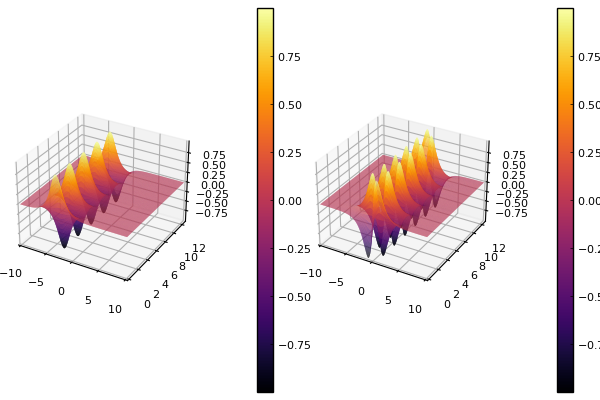

In [2]:
f1(x,t) = sech(x+3) *(exp(2.3im*t))
f2(x,t) = 2*sech(x)*tanh(x)*exp(2.8im*t) 

x1 = range(-10, stop=10, length= 400)
t1 = range(0, stop=4*pi, length = 200)
dt = t1[2]-t1[1]

f1_data = [f1(x,t) for x in x1, t in t1]
f2_data = [f2(x,t) for x in x1, t in t1]

p1 = surface(x1,t1,real(f1_data)')
p2 = surface(x1,t1,real(f2_data)')

#p1 = heatmap(x1,t1,real(f1_data)')
#p2 = heatmap(x1,t1,real(f2_data)')

plot(p1, p2, layout=(1,2))

The plot below shows the function 
$$ 
f(x,t) = f_1(x,t) + f_2(x,t),
$$
we want to approximate via DMD. We also generate the full data matrix X. 

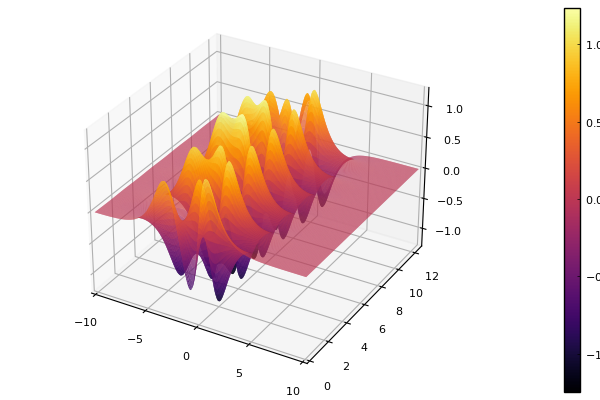

In [3]:
#data matrix X
X = f1_data + f2_data

p3 = surface(x1,t1,real(X)')
#p3 = heatmap(x1,t1,real(X)')
plot(p3)

In the next step we create the DMD matrices (here called $X_1$ and $X_2$) by
$$
X_1= [x_0, \ldots, x_{K-1} ], \quad X_2= [x_1, \ldots, x_{K} ]
$$
such that we seek
$$
A = X_2 X_1^{\dagger},
$$
where $\cdot^{\dagger}$ denotes the Moore-Penrose pseudoinverse. 

In [4]:
#create DMD data matrices
X1 = X[:, 1:end-1];
X2 = X[:, 2:end];

Next, we compute the SVD of $X_1$ in order to subsequently compute the pseudoinverse:
$$
X_1 = U \Sigma V^{\ast},
$$
and truncate the matrices. We arrive at the approximation
$$
X_1 \approx \tilde{U} \tilde{\Sigma} \tilde{V}^{\ast}.
$$

In [5]:
#SVD and rank truncation - here rank 2
r=2
SVDX = svd(X1)

#truncate matrices
Utilde = SVDX.U[:,1:r];
S = Diagonal(SVDX.S);
Stilde = S[1:r,1:r];
Vtilde = SVDX.V[:,1:r];

Next, we compute 
$$
\tilde{A} = \tilde{U}^{*} X_2 \tilde{V} \tilde{\Sigma}^{-1}, 
$$ 
perform the eigendecomposition of $\tilde{A}$ and compute the dynamic modes $\phi$ of $\bar{A}.$

In [6]:
Atilde = Utilde'*X2*Vtilde/Stilde;
Lambda = Diagonal(eigvals(Atilde));
W = eigvecs(Atilde)
omega = log(Lambda)/dt;
Phi = X2*Vtilde/Stilde*W; # DMD Modes

Compute the DMD solution via 
$$
x(t)= \Phi \exp(\Omega t)b,
$$
where b are the coordinates of the initial condition in eigenvector basis.

In [7]:
#compute dmd solution
x_1 = X[:, 1];
b = Phi\x_1; 

time_dynamics = Matrix(undef, 2, 0)
for iter in range(1,stop=200)
    time_dynamics = hcat(time_dynamics,exp(omega*t1[iter])*b) 
end 

X_dmd = Phi*time_dynamics;

We take a look at the solution. 

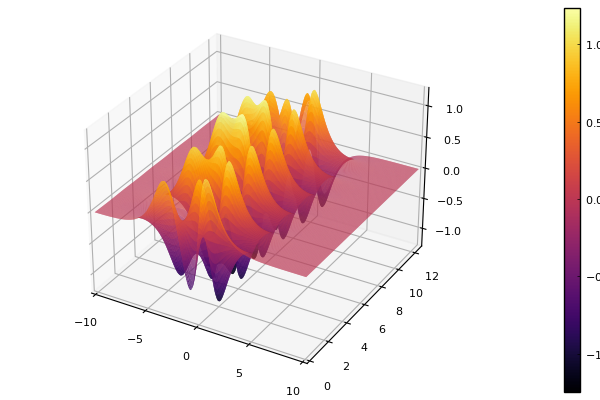

In [8]:
p4 = surface(x1,t1,real(X_dmd)') 
#p4 = heatmap(x1,t1,real(X_dmd)')
plot(p4)

In order to have something more rigorius than the eyeball-norm, we plot the error in the solution and compute the norm.  

1.0976384933237935e-11

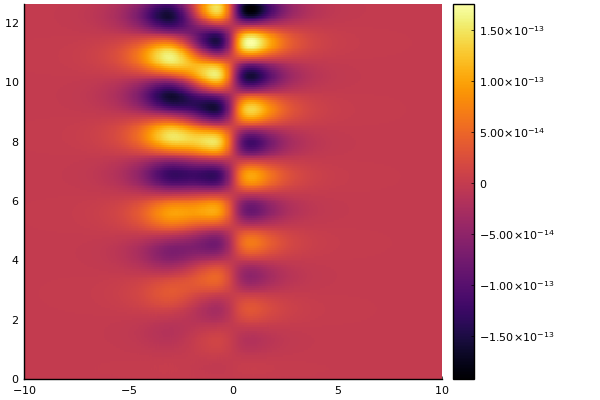

In [9]:
#plot Error
p5 = heatmap(x1,t1,real(X)'- real(X_dmd)')
print(norm(real(X)-real(X_dmd)))
plot(p5)

# 2) Dynamic mode decomposition and it's limitations

Again, we look at the DMD approximation of the sum of two functions with a slight change in function $f_1$:
$$
f_1(x,t) := \text{sech}(x+6-t)\exp(i 2.3 t), \\ 
f_2(x,t) := \text{sech}(x)\tanh(x)\exp(i 2.8 t).
$$
Here, the function $f_1$ is translating at a constant velocity across the spatial domain. Again, we take a look at those two functions separately and then combined.

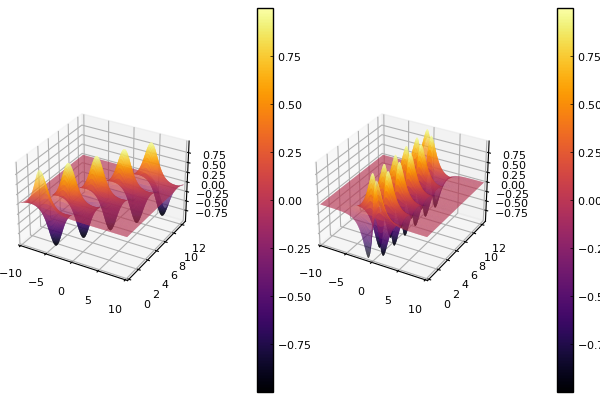

In [10]:
f1_shift(x,t) = sech(x+6-t) *(exp(2.3im*t))
f2_shift(x,t) = 2*sech(x)*tanh(x)*exp(2.8im*t)

x1 = range(-10, stop=10, length= 400)
t1 = range(0, stop=4*pi, length = 200)
dt = t1[2]-t1[1]

f1_data_shift = [f1_shift(x,t) for x in x1, t in t1]
f2_data_shift = [f2_shift(x,t) for x in x1, t in t1]

p6 = surface(x1,t1,real(f1_data_shift)')
p7 = surface(x1,t1,real(f2_data_shift)')

#p6 = heatmap(x1,t1,real(f1_data_shift)')
#p7 = heatmap(x1,t1,real(f2_data_shift)')

plot(p6, p7, layout=(1,2))

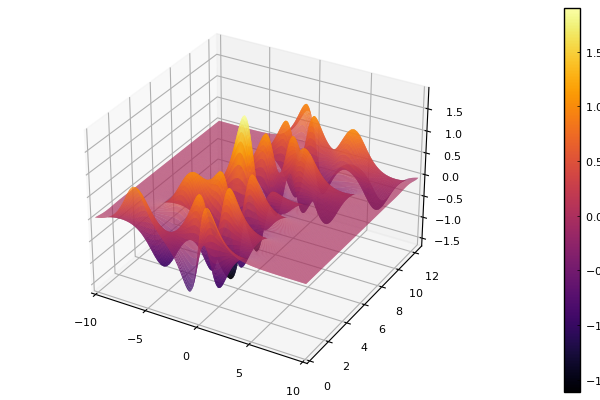

In [11]:
#data matrix X
X_shift = f1_data_shift + f2_data_shift

p8 = surface(x1,t1,real(X_shift)')
#p8 = heatmap(x1,t1,real(X_shift)')
plot(p8)

As before we create the data matrices and perform the SVD with rank truncation. In the next steps, we compute the eigendynamics of our system. 

In [12]:
#create DMD data matrices
X1_shift = X_shift[:, 1:end-1];
X2_shift = X_shift[:, 2:end];

#SVD and rank truncation - here rank 2
r_shift=2
SVDX_shift = svd(X1_shift)

#truncate matrices
Utilde_shift = SVDX_shift.U[:,1:r_shift];
S_shift = Diagonal(SVDX_shift.S);
Stilde_shift = S_shift[1:r_shift,1:r_shift];
Vtilde_shift = SVDX_shift.V[:,1:r_shift];

In [13]:
Atilde_shift = Utilde_shift'*X2_shift*Vtilde_shift/Stilde_shift;
Lambda_shift = Diagonal(eigvals(Atilde_shift));
W_shift = eigvecs(Atilde_shift)
omega_shift = log(Lambda_shift)/dt;
Phi_shift = X2_shift*Vtilde_shift/Stilde_shift*W_shift; 

In [14]:
#compute dmd solution
x_1_shift = X_shift[:, 1];
b_shift = Phi_shift\x_1_shift; 

time_dynamics_shift = Matrix(undef, r_shift, 0)
for iter in range(1,stop=200)
    time_dynamics_shift = hcat(time_dynamics_shift,exp(omega_shift*t1[iter])*b_shift) 
end 

X_dmd_shift = Phi_shift*time_dynamics_shift;

Finally, we take a look at the results - via plot and via computing the error. 

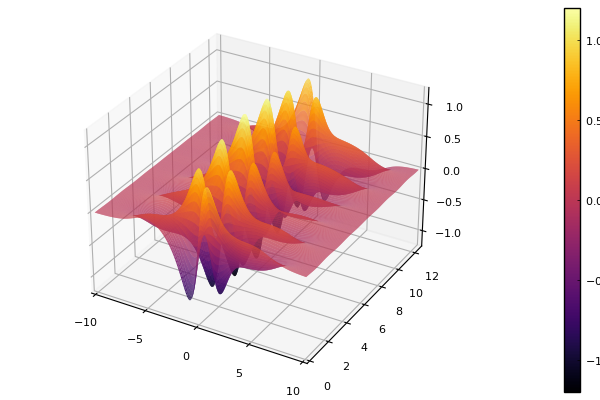

In [15]:
p9 = surface(x1,t1,real(X_dmd_shift)') 
#p9 = heatmap(x1,t1,real(X_dmd_shift)')
plot(p9)

This plot does not seem to approximate out original data very well. We confirm with the difference in norm and a plot of the error. 

55.57344155390994

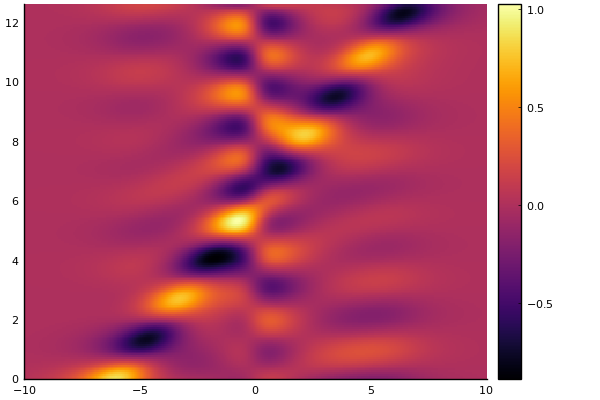

In [16]:
#plot Error
p10 = heatmap(x1,t1,real(X_shift)'- real(X_dmd_shift)')
print(norm(real(X_shift)-real(X_dmd_shift)))
plot(p10)

## Questions to work on:
1) Those results do not look as good as for the first example. Do you have an idea how they could be improved? 

2) What would you in generell include in the code to get a better approximation?

3) Can you think of ways of overcoming this issue with other methods than modifying DMD?
